#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import time
import datetime
import os
import numpy as np
import math
from pandas.api.types import is_string_dtype, is_numeric_dtype
from statsmodels.tsa.seasonal import seasonal_decompose 

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace import sarimax

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-deep')
STATE = 12345

In [2]:
# напишем функцию для поиска файла на локальном диске: 
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [3]:
# найдем файл на диске или онлайн: 

online_path = 'datasets'
offline_path = '/home/alex/Документы/'
file = 'taxi.csv'


try:
    df = pd.read_csv(f'/{online_path}/{file}', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path), index_col=[0], parse_dates=[0])
    print(f"Файл {file} найден на локальном диске.")
else:
    print(f"Файл {file} открыт в режиме online.")

Файл taxi.csv найден на локальном диске.


In [4]:
# отсортируем датафрейм по индексу: 
df.sort_index(ascending=True, inplace=True)

### Развёрнутая сводка по датафрейму

Внешний вид первых пяти строк датафрейма TAXI:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Размер датафрейма TAXI:         
количество строк - 26496, 
количество столбцов - 1.

Развернутая сводка датафрейма TAXI 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Пропуски в столбцах датафрейма TAXI:


num_orders    0
dtype: int64

Статистические данные по столбцам датафрейма TAXI, содержащим численные значения:


,num_orders
count,26496.000
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


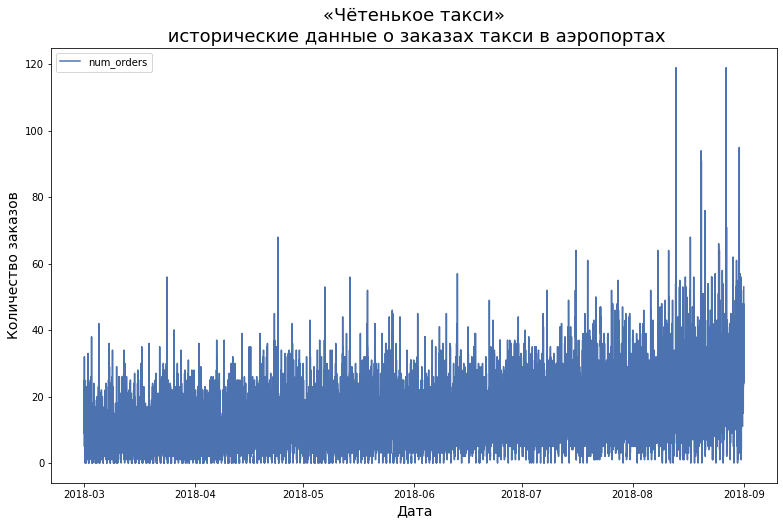

In [5]:
start = "\033[1m"
end = "\033[0;0m"
print(
    f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
display(df.head())
print()
print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df.shape[0]}, \nколичество столбцов - {df.shape[1]}."
      )
print()
print(
    f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
)
print()
df.info(show_counts=True, memory_usage='deep')
print()
print(
    f"Пропуски в столбцах датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
)
display(df.isna().sum())

print(
    f"Статистические данные по столбцам датафрейма {start}{str(file).split('.')[0].upper()}{end}, содержащим численные значения:"
)
display(df.describe(include=np.number))

fig, ax = plt.subplots(figsize=(13, 8))
plot = sns.lineplot(ax=ax, data=df, legend='auto')
plot.set_title(
    '«Чётенькое такси»\n исторические данные о заказах такси в аэропортах',
    fontsize=18)
plot.set_xlabel("Дата", fontsize=14)
plot.set_ylabel("Количество заказов", fontsize=14)
plt.show()

## Анализ

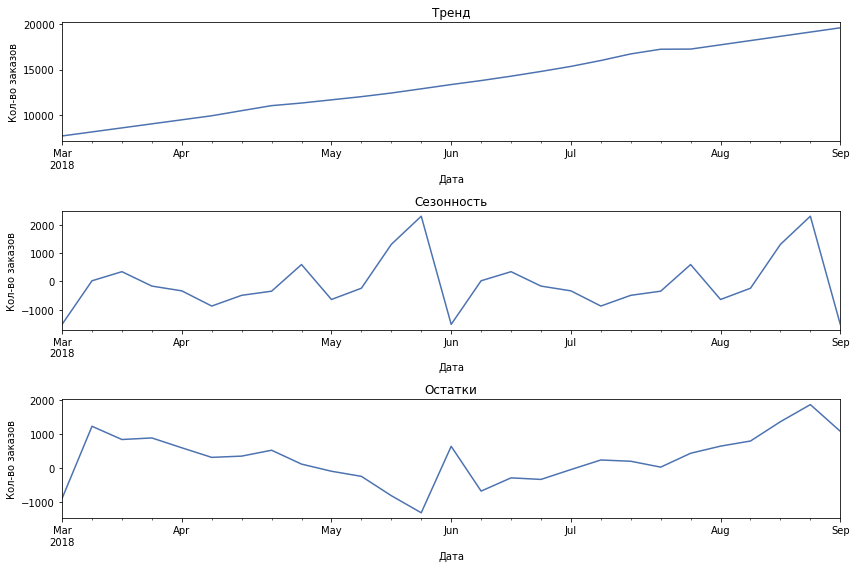

In [6]:
data = df.resample('W').sum()

decomposed = seasonal_decompose(x=data['num_orders'],
                                model='additive',
                                extrapolate_trend='freq',
                                period=13)
plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.tight_layout()

In [7]:
# проведем ресемплирование датафрейма по часу: 
df = df.resample('1H').sum()

In [8]:
# проверим полученный результат: 
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# получим данные скользящего среднего и стандатрного отклонения со сдвигом 24 часа: 
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df = df.dropna()

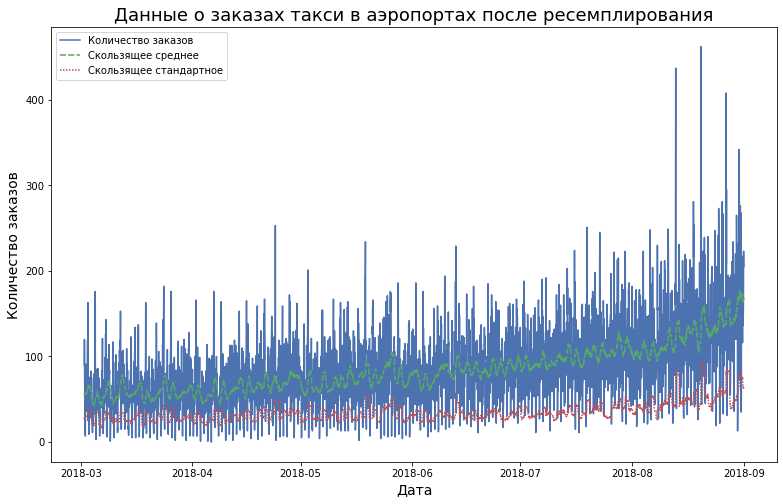

In [10]:
# построим график после ресемплирования с указанием скользящего среднего и отклонения: 
fig, ax = plt.subplots(figsize=(13, 8))
resample_plot = sns.lineplot(ax=ax, data=df)
resample_plot.set_title(
    'Данные о заказах такси в аэропортах после ресемплирования', fontsize=18)
plt.legend(['Количество заказов', 'Скользящее среднее', 'Скользящее стандартное'])
resample_plot.set_xlabel("Дата", fontsize=14)
resample_plot.set_ylabel("Количество заказов", fontsize=14)
plt.show()

Данные датасета не стационарны,т.к. и скользящее среднее и стандартное отклонение не одинаковы. Имеется явно выраженный тренд и сезонность. 

## Обучение и тестирование

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:, 0].shift(lag)

    data['rolling_mean'] = data.iloc[:, 0].shift().rolling(
        rolling_mean_size).mean()

In [12]:
make_features(df, 11, 33)
df.dropna(how='any', inplace=True)

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [14]:
print(f'Размер обучающей выборки: {train.shape[0]} \nРазмер тестовой выборки: {test.shape[0]}')

Размер обучающей выборки: 3923 
Размер тестовой выборки: 436


In [15]:
print("Среднее количество заказов такси в час:", int(test['num_orders'].mean()))

pred_previous = test.shift()
pred_previous.iloc[0]=train.iloc[-1]
print("MAE:",round(mean_absolute_error(test, pred_previous), 3) )

Среднее количество заказов такси в час: 139
MAE: 34.183


In [16]:
features_train = train.drop('num_orders', axis='columns')
target_train = train['num_orders']

features_test = test.drop('num_orders', axis='columns')
target_test = test['num_orders']

### LinearRegression

In [17]:
# напишем функцию обучения модели линейной регрессии:
def model_train(model, features_train, features_test):
    start = time.time()
    train_rmse = (cross_val_score(model,
                                  features_train,
                                  target_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error').mean() *
                  -1)**0.5
    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))

    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title('Корреляция реальных данных и предсказаний \nпервая неделя',
              fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Количество такси', fontsize=14)
    plt.plot(target_test.index[0:168], target_test[0:168], label="Real data")
    plt.plot(features_test.index[0:168],
             prediction[0:168],
             label="Prediction",
             color='r')
    plt.legend()
    plt.show()

    return model_dict

Среднее значение RMSE для кроссвалидации модели LinearRegression(): 30.78    
Время обучения: 0:00:00.037749

********************************************************************************

Среднее значение RMSE для модели LinearRegression() на тестовой выборке: 50.44    
Время предсказания: 0:00:00.001892


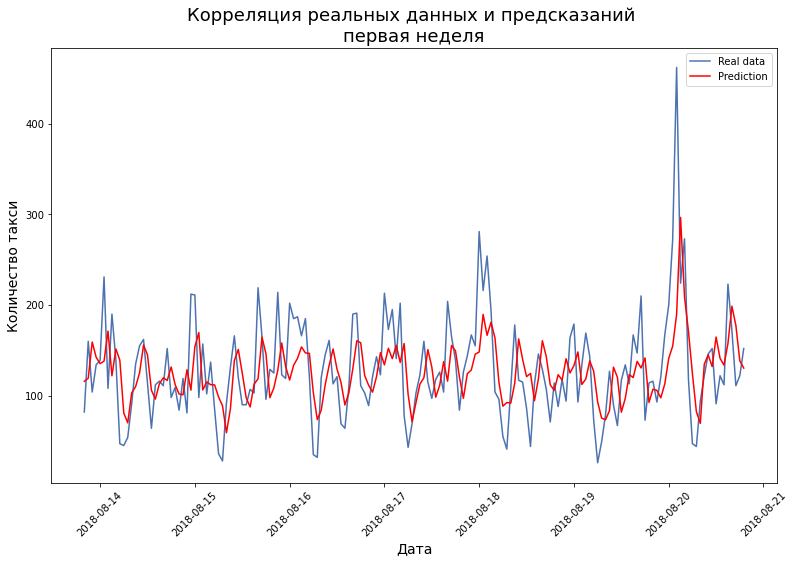

In [18]:
lr_results = model_train(LinearRegression(), features_train, features_test)

### Модель - DecisionTreeRegressor

In [19]:
# напишем функцию для моделей DecisionTreeRegressor:
def dt_model_train(model, model_selector, param_grid, features_train,
                   features_test):
    start = time.time()
    grid = model_selector(model,
                          param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

    grid.fit(
        features_train,
        target_train,
    )

    end = time.time()
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(grid.best_estimator_)

    train_rmse = (max(grid.cv_results_['mean_test_score']) * -1)**0.5
    train_time = datetime.timedelta(seconds=(end - start))

    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = grid.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title('Корреляция реальных данных и предсказаний \nпервая неделя', fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Количество такси', fontsize=14)
    plt.plot(target_test.index[0:168], target_test[0:168], label="Real data")
    plt.plot(features_test.index[0:168],
             prediction[0:168],
             label="Prediction",
             color='r')
    plt.legend()
    plt.show()

    return model_dict

In [20]:
depth = [x for x in range(1, 10)]
param_grid = [{
    'criterion': ['squared_error'],
    'max_depth': depth,
    'random_state': [STATE]
}]

Наилучшие параметры модели на обучающей выборке:

DecisionTreeRegressor(max_depth=7, random_state=12345)
Среднее значение RMSE для кроссвалидации модели DecisionTreeRegressor(): 28.79    
Время обучения: 0:00:01.545542

********************************************************************************

Среднее значение RMSE для модели DecisionTreeRegressor() на тестовой выборке: 48.55    
Время предсказания: 0:00:00.002537


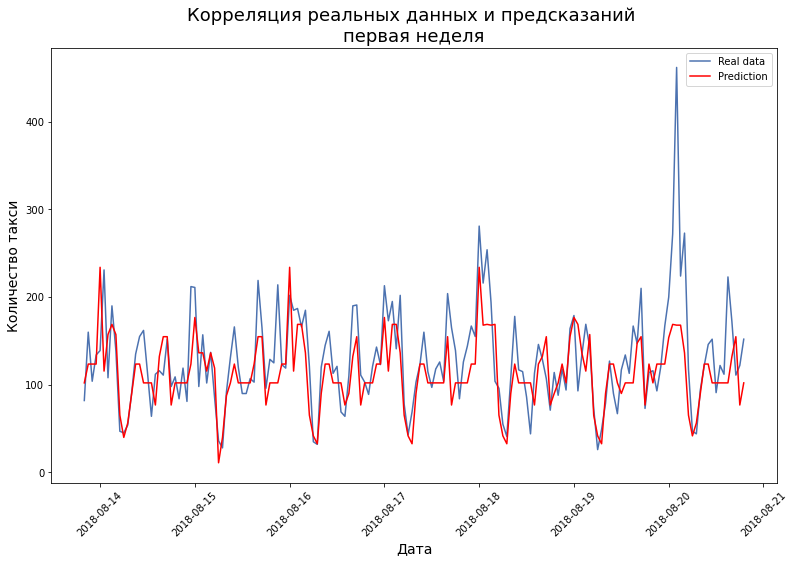

In [21]:
dt_results = dt_model_train(model=DecisionTreeRegressor(),
                       model_selector=GridSearchCV,
                       param_grid=param_grid,
                       features_train=features_train,
                       features_test=features_test)

### Модель - RandomForestRegressor

In [22]:
# напишем функцию для моделей RandomForestRegressor:
def rf_model_train(model, model_selector, param_dist, features_train,
                   features_test, n_iter, verbose):
    start = time.time()
    rand = model_selector(model,
                          param_dist,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_iter=n_iter,
                          random_state=STATE,
                          verbose=verbose)

    rand.fit(
        features_train,
        target_train,
    )

    end = time.time()
    print('Наилучшие параметры модели на обучающей выборке:')
    print()
    print(rand.best_estimator_)

    train_rmse = (max(rand.cv_results_['mean_test_score']) * -1)**0.5
    train_time = datetime.timedelta(seconds=(end - start))
    print(
        f'Среднее значение RMSE для кроссвалидации модели {model}: {round(train_rmse, 2)}\
    \nВремя обучения: {train_time}')
    print()
    print(
        '********************************************************************************'
    )
    print()

    start = time.time()
    prediction = rand.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))

    rmse = mean_squared_error(target_test, prediction, squared=False)
    print(
        f'Среднее значение RMSE для модели {model} на тестовой выборке: {round(rmse, 2)}\
    \nВремя предсказания: {execution_time}')
    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(rmse, 2),
    }
    
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title('Корреляция реальных данных и предсказаний \nпервая неделя', fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Количество такси', fontsize=14)
    plt.plot(target_test.index[0:168], target_test[0:168], label="Real data")
    plt.plot(features_test.index[0:168],
             prediction[0:168],
             label="Prediction",
             color='r')
    plt.legend()
    plt.show()
    
    return model_dict

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Наилучшие параметры модели на обучающей выборке:

RandomForestRegressor(max_depth=5, n_estimators=91)
Среднее значение RMSE для кроссвалидации модели RandomForestRegressor(): 27.15    
Время обучения: 0:00:07.285737

********************************************************************************

Среднее значение RMSE для модели RandomForestRegressor() на тестовой выборке: 50.51    
Время предсказания: 0:00:00.008140


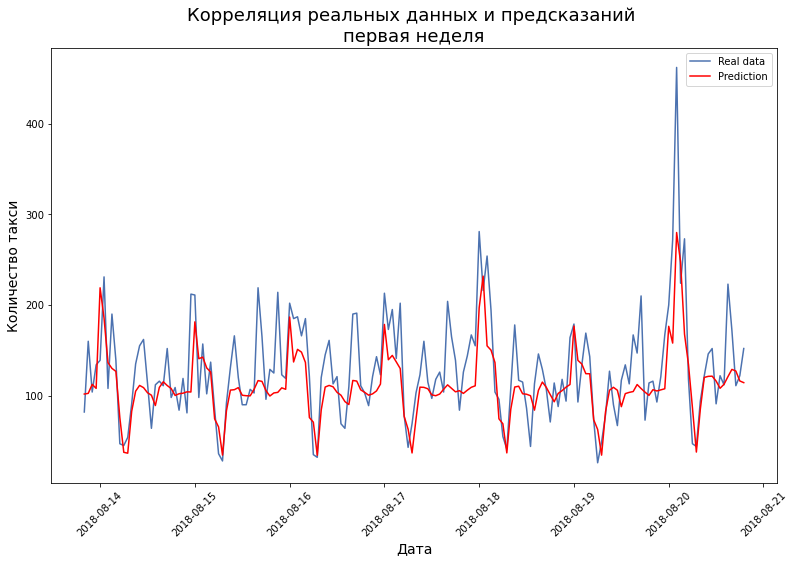

In [23]:
depth = [x for x in range(1, 6)]
param_dist = {'n_estimators': list(range(90, 95)), 'max_depth': depth}

rf_results = rf_model_train(model=RandomForestRegressor(),
                       model_selector=RandomizedSearchCV,
                       param_dist=param_dist,
                       features_train=features_train,
                       features_test=features_test,
                       n_iter=2,
                       verbose=1)

### Модель - CatBoostRegressor

In [24]:
# напишем функцию для моделей CatBoostRegressor:
def cbr_model_train(model,
                    features_train,
                    features_test,
                    learning_rate,
                    random_state,
                    verbose,
                    iterations=200,
                    cat_features=[]):
    start = time.time()
    model = model(learning_rate=learning_rate,
                  iterations=iterations,
                  random_state=random_state,
                  verbose=verbose,
                  cat_features=cat_features)

    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    print(f'Время обучения: {train_time}')

    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    rmse = math.sqrt(mean_squared_error(target_test, prediction))
    print(f'Время предсказания для модели {model}: {execution_time}')
    print(
        f'Среднее значение RMSE для тестовых данных модели {model}: {round(rmse, 2)}'
    )

    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': '-',
        'Test RMSE': round(rmse, 2),
    }

    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title('Корреляция реальных данных и предсказаний \nпервая неделя', fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Количество такси', fontsize=14)
    plt.plot(target_test.index[0:168], target_test[0:168], label="Real data")
    plt.plot(features_test.index[0:168],
             prediction[0:168],
             label="Prediction",
             color='r')
    plt.legend()
    plt.show()

    return model_dict

Время обучения: 0:00:00.390194
Время предсказания для модели <catboost.core.CatBoostRegressor object at 0x7fb4ec1a0c70>: 0:00:00.001768
Среднее значение RMSE для тестовых данных модели <catboost.core.CatBoostRegressor object at 0x7fb4ec1a0c70>: 45.92


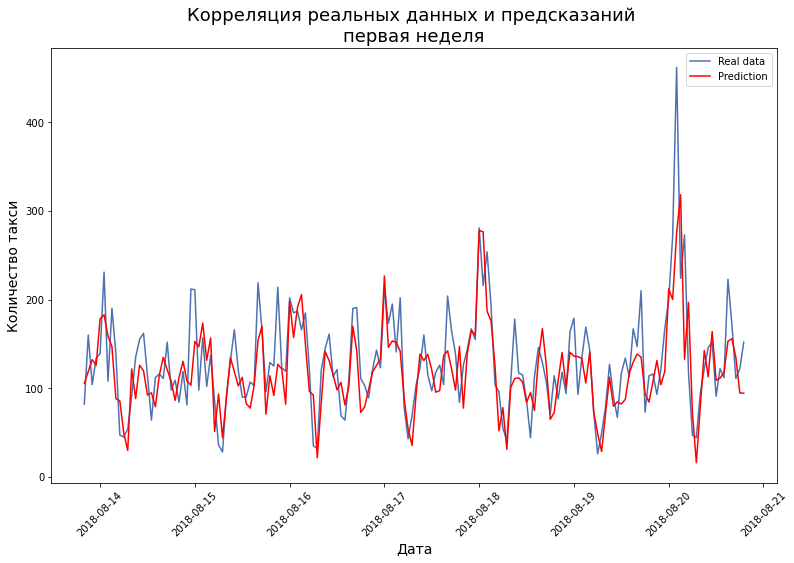

{'Model': <catboost.core.CatBoostRegressor at 0x7fb4ec1a0c70>,
 'Train time': 0.390194,
 'Predict time': 0.001768,
 'Train RMSE': '-',
 'Test RMSE': 45.92}

In [25]:
cbr_results = cbr_model_train(
    model=CatBoostRegressor,
    features_train=features_train,
    features_test=features_test,
    learning_rate=0.5,
    random_state=STATE,
    verbose=False)
cbr_results

### Модель - LGBMRegressor

In [26]:
# напишем функцию для моделей LGBMRegressor:
def lgbm_model_train(model,
                     features_train,
                     features_test,
                     learning_rate,
                     num_leaves,
                     max_depth,
                     boosting_type,
                     random_state=STATE):
    start = time.time()
    model = model(learning_rate=learning_rate,
                  num_leaves=num_leaves,
                  max_depth=max_depth,
                  boosting_type=boosting_type)

    model.fit(features_train, target_train)
    end = time.time()
    train_time = datetime.timedelta(seconds=(end - start))
    print(f'Время обучения: {train_time}')

    start = time.time()
    prediction = model.predict(features_test)
    end = time.time()
    execution_time = datetime.timedelta(seconds=(end - start))
    rmse = math.sqrt(mean_squared_error(target_test, prediction))
    print(f'Время предсказания для модели {model}: {execution_time}')
    print(
        f'Среднее значение RMSE для тестовых данных модели {model}: {round(rmse, 2)}'
    )

    model_dict = {
        'Model': model,
        'Train time': train_time.total_seconds(),
        'Predict time': execution_time.total_seconds(),
        'Train RMSE': '-',
        'Test RMSE': round(rmse, 2),
    }
    
    fig, ax = plt.subplots(figsize=(13, 8))
    plt.title('Корреляция реальных данных и предсказаний \nпервая неделя', fontsize=18)
    plt.xlabel('Дата', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Количество такси', fontsize=14)
    plt.plot(target_test.index[0:168], target_test[0:168], label="Real data")
    plt.plot(features_test.index[0:168],
             prediction[0:168],
             label="Prediction",
             color='r')
    plt.legend()
    plt.show()
    
    return model_dict

Время обучения: 0:00:00.309816
Время предсказания для модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 0:00:00.002625
Среднее значение RMSE для тестовых данных модели LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
              num_leaves=200): 58.65


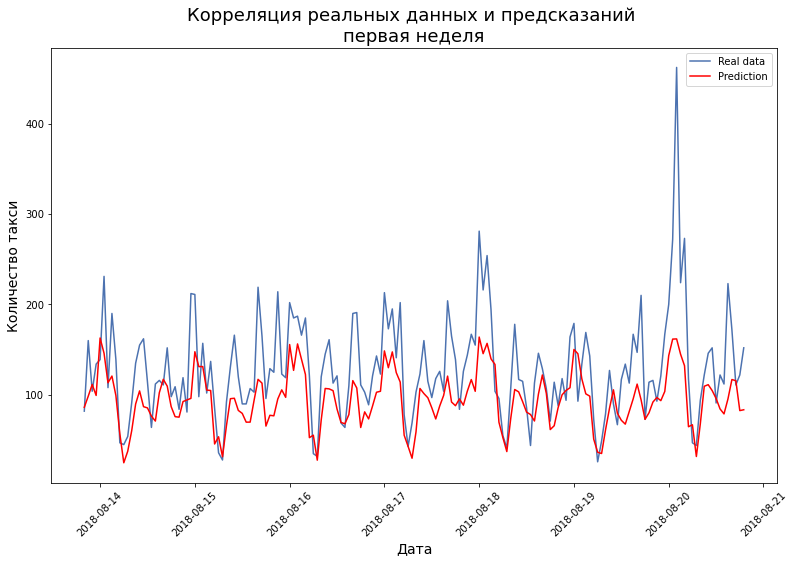

{'Model': LGBMRegressor(boosting_type='dart', learning_rate=0.05, max_depth=10,
               num_leaves=200),
 'Train time': 0.309816,
 'Predict time': 0.002625,
 'Train RMSE': '-',
 'Test RMSE': 58.65}

In [27]:
lgbm_results = lgbm_model_train(LGBMRegressor,
                     features_train,
                     features_test,
                     learning_rate=0.05,
                     num_leaves=200,
                     max_depth=10,
                     boosting_type='dart')
lgbm_results

### Модель - ARIMA

In [28]:
# проведем автоматический подбор параметров модели: 
model = auto_arima(features_train.iloc[:, 0], 
                  seasonal=True, 
                  m=7, 
                  trace=True, 
                  suppress_warnings=True, 
                  errror_action='ignore', 
                  stepwise=True, 
                  trend='t')
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=13599.517, Time=3.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14605.693, Time=0.53 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13627.206, Time=1.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13890.506, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14605.693, Time=0.52 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=13597.898, Time=2.79 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=13596.103, Time=1.29 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=13614.747, Time=2.38 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=13594.768, Time=1.09 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=13613.025, Time=1.80 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=13596.587, Time=2.29 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=13598.214, Time=2.80 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=13646.253, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=13606.194, Time=1.94 sec
 ARIMA(1,1,3)(0,0,0

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,4)(0,0,0)[7] intercept   : AIC=14779.493, Time=2.00 sec
 ARIMA(0,1,3)(0,0,0)[7]             : AIC=13590.979, Time=0.83 sec

Best model:  ARIMA(0,1,3)(0,0,0)[7]          
Total fit time: 39.624 seconds


ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, trend='t', with_intercept=False)

In [29]:
# т.к. модель имеет выраженную сезонность используем модкль SARIMAX: 
arima_model = sarimax.SARIMAX(features_train.iloc[:, 0],
                                        order=(0, 1, 3),
                                        seasonal_order=(0, 0, 0, 7))
arima_results = arima_model.fit()
print(arima_results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73098D+00    |proj g|=  5.44648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   1.038D-06   1.731D+00
  F =   1.7309512878591580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4477      0.014     31.457      0.000       0.420       0.476
ma.L2          0.2758      0.016     17.243      0.000       0.244       0.307
ma.L3          0.1176      0.016      7.487      0.000       0.087       0.148
sigma2         1.8679      0.038     49.261      0.000       1.794       1.942


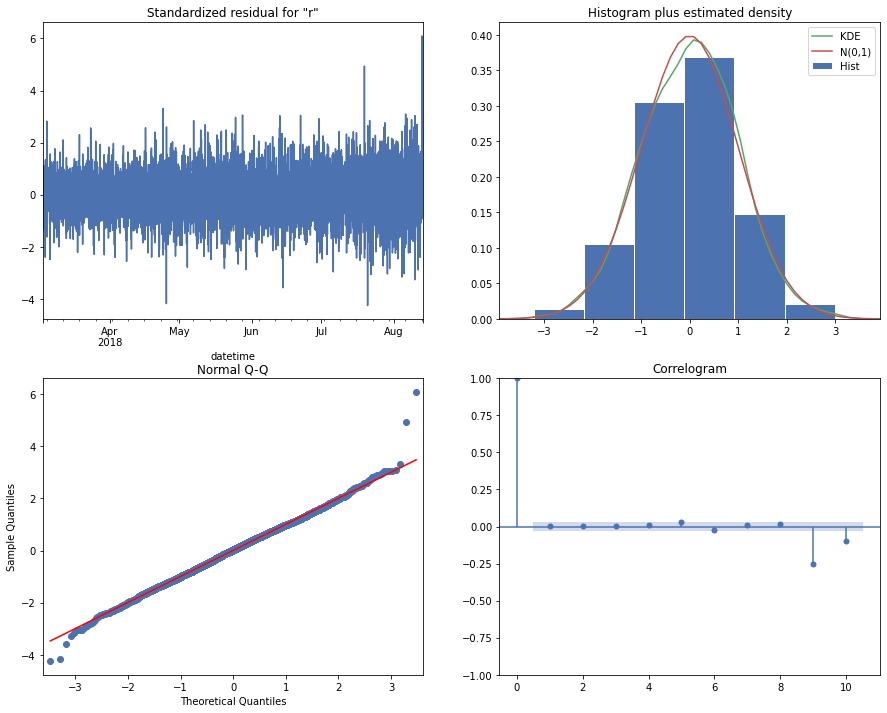

In [30]:
arima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

Стандартизированные остатки указывают на наличие выбросов, которые могут оказывать влияние на точность предсказаний модели. Однако, распределение ошибок имеет колоколообразную форму - близкую к идеальной. Наибольшее отклонение ошибки получаем на минимальных и максимальных значениях выборки. 

In [31]:
# получим rmse для обучающей выборки:
train_predict = arima_results.get_prediction()
print(train_predict.predicted_mean[:10])
arima_train_rmse = np.sqrt(
    mean_squared_error(features_train.iloc[:, 0],
                       train_predict.predicted_mean))
print(features_train.iloc[:10, 0])
print(arima_train_rmse)

datetime
2018-03-03 09:00:00    0.000
2018-03-03 10:00:00   60.818
2018-03-03 11:00:00   60.062
2018-03-03 12:00:00   57.299
2018-03-03 13:00:00   57.335
2018-03-03 14:00:00   56.353
2018-03-03 15:00:00   57.126
2018-03-03 16:00:00   58.315
2018-03-03 17:00:00   60.815
2018-03-03 18:00:00   61.638
Freq: H, Name: predicted_mean, dtype: float64
datetime
2018-03-03 09:00:00   60.818
2018-03-03 10:00:00   60.303
2018-03-03 11:00:00   58.242
2018-03-03 12:00:00   57.697
2018-03-03 13:00:00   56.727
2018-03-03 14:00:00   56.970
2018-03-03 15:00:00   57.879
2018-03-03 16:00:00   59.848
2018-03-03 17:00:00   61.030
2018-03-03 18:00:00   61.121
Freq: H, Name: rolling_mean, dtype: float64
1.6764110459494335


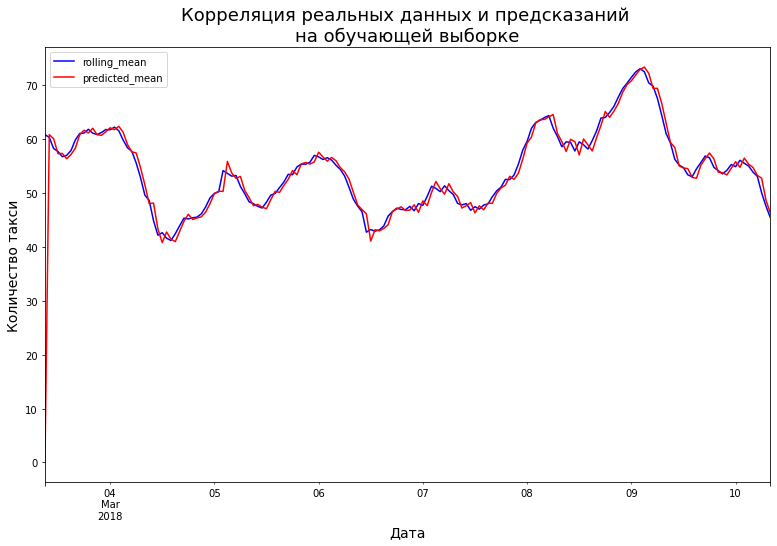

In [32]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.title('Корреляция реальных данных и предсказаний \nна обучающей выборке',
          fontsize=18)

features_train.iloc[0:168, 0].plot(color='b')
train_predict.predicted_mean[0:168].plot(color='r')
plt.xlabel('Дата', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Количество такси', fontsize=14)
plt.legend()
plt.show()

In [33]:
# получим rmse для тестовой выборки:
test_predict = arima_results.get_prediction(
    start=pd.to_datetime('2018-08-13 20:00:00'),
    end=pd.to_datetime('2018-08-31 23:00:00'))
print(test_predict.predicted_mean[:10])
arima_test_rmse = np.sqrt(
    mean_squared_error(features_test.iloc[:, 0], test_predict.predicted_mean))
print(features_test.iloc[:10, 0])
print(arima_test_rmse)


2018-08-13 20:00:00   134.083
2018-08-13 21:00:00   133.820
2018-08-13 22:00:00   133.717
2018-08-13 23:00:00   133.717
2018-08-14 00:00:00   133.717
2018-08-14 01:00:00   133.717
2018-08-14 02:00:00   133.717
2018-08-14 03:00:00   133.717
2018-08-14 04:00:00   133.717
2018-08-14 05:00:00   133.717
Freq: H, Name: predicted_mean, dtype: float64
datetime
2018-08-13 20:00:00   133.848
2018-08-13 21:00:00   133.879
2018-08-13 22:00:00   135.000
2018-08-13 23:00:00   134.515
2018-08-14 00:00:00   135.424
2018-08-14 01:00:00   135.121
2018-08-14 02:00:00   137.485
2018-08-14 03:00:00   137.273
2018-08-14 04:00:00   140.667
2018-08-14 05:00:00   142.394
Freq: H, Name: rolling_mean, dtype: float64
15.973685513674774


In [35]:
sarima_results = {
        'Model': arima_results,
        'Train time': '-',
        'Predict time': '-',
        'Train RMSE': round(arima_train_rmse, 2),
        'Test RMSE': round(arima_test_rmse, 2),
    }

## Анализ моделей

In [36]:
rating = {
    'LinearRegression':lr_results,
    'DecisionTreeRegressor':dt_results, 
    'RandomForestRegressor': rf_results, 
    'CatBoostRegressor':cbr_results, 
    'LGBMRegressor': lgbm_results,
    'SARIMA model': sarima_results,
    
}

In [37]:
analysis_df = pd.DataFrame(rating).T

In [38]:
analysis_df

,Model,Train time,Predict time,Train RMSE,Test RMSE
LinearRegression,LinearRegression(),0.038,0.002,30.780,50.440
DecisionTreeRegressor,DecisionTreeRegressor(),1.546,0.003,28.790,48.550
RandomForestRegressor,RandomForestRegressor(),7.286,0.008,27.150,50.510
CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x7...,0.390,0.002,-,45.920
LGBMRegressor,"LGBMRegressor(boosting_type='dart', learning_r...",0.310,0.003,-,58.650
SARIMA model,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,-,-,1.680,15.970


## Вывод

Традиционные модели показывают не лучший результат на временных рядах. 
SARIMA модель с автоподбором параметров наиболее точно описывает временной ряд и позволяет получить наиболее точный прогноз. 
При этом наибольшее время занимает автоматический подбор параметров модели. 